In [ ]:
'''
Deep Learning Stock Price Predictor 
Author: Gil Akos
Objective: Create Deep Learning Model with Stacked Keras LSTM using Adjusted Close Parameter
Reference: http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

Develop Stacked Model per DLNDF
'''

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import required libraries for Machine Learning
import math
import numpy as np
# Fix random seed for reproducibility
np.random.seed(7)
import pandas as pd

# Import Keras Libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Merge
from keras.layers import Activation, Dropout
from keras.metrics import mean_squared_error

# Import fix for Tensorflow 1.0 control flow ops w/ Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

# Import required libraries for Yahoo Finance API
import yahoo_finance as yf
from yahoo_finance import Share

# Import required libraries for visualization and printing
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)
import matplotlib.dates as mdates

# Import utility libraries
import utilities as util
import datetime
import time

Using TensorFlow backend.


In [24]:
# Set Benchmark Dates based on Machine Learning for Trading course 1/1/09-6/18/15
date_start, date_end = '1995-01-01', '2015-06-18'#'2015-06-18'

# Set Additional Tickers
tick_0 = 'SPY'
tick_1 = 'GE'
tick_2 = 'MSFT'
tick_3 = 'AAPL'

# Set Baseline Model Ticker
base_ticker = tick_3

In [25]:
#Request Stock Data
stock_data = Share(base_ticker)
stock_historical = stock_data.get_historical(date_start,date_end)

#pprint(stock_historical)

#Define columns of data to keep from historical stock data
stock_item = []
stock_date = []
stock_close = []
stock_volume = []

#Loop through the stock data objects backwards and store factors we want to keep
i_counter = 0
for i in xrange(len(stock_historical)-1,-1,-1):
    d = stock_historical[i]
    stock_item.append(i_counter+1)
    stock_date.append(d['Date'])
    stock_close.append(d['Adj_Close'])
    stock_volume.append(d['Volume'])
    i_counter += 1

#Create a dataframe for stock data
stock_df = pd.DataFrame()
    
#Add factors to dataframe
stock_df['Item'] = stock_item
stock_df['Date'] = stock_date
stock_df['Adj_Close'] = pd.to_numeric(stock_close)
stock_df['Volume'] = pd.to_numeric(stock_volume)

#Print the dataframe head and tail
print(stock_df.head())
print("---")
print(stock_df.tail())

   Item        Date  Adj_Close     Volume
0     1  1995-01-03   1.228913   25967200
1     2  1995-01-04   1.260937   39670400
2     3  1995-01-05   1.244925   18410000
3     4  1995-01-06   1.344999  269155600
4     5  1995-01-09   1.319479   68521600
---
      Item        Date   Adj_Close    Volume
5147  5148  2015-06-12  122.781413  36886200
5148  5149  2015-06-15  122.540040  43988900
5149  5150  2015-06-16  123.196574  31494100
5150  5151  2015-06-17  122.906931  32918100
5151  5152  2015-06-18  123.466910  35407200


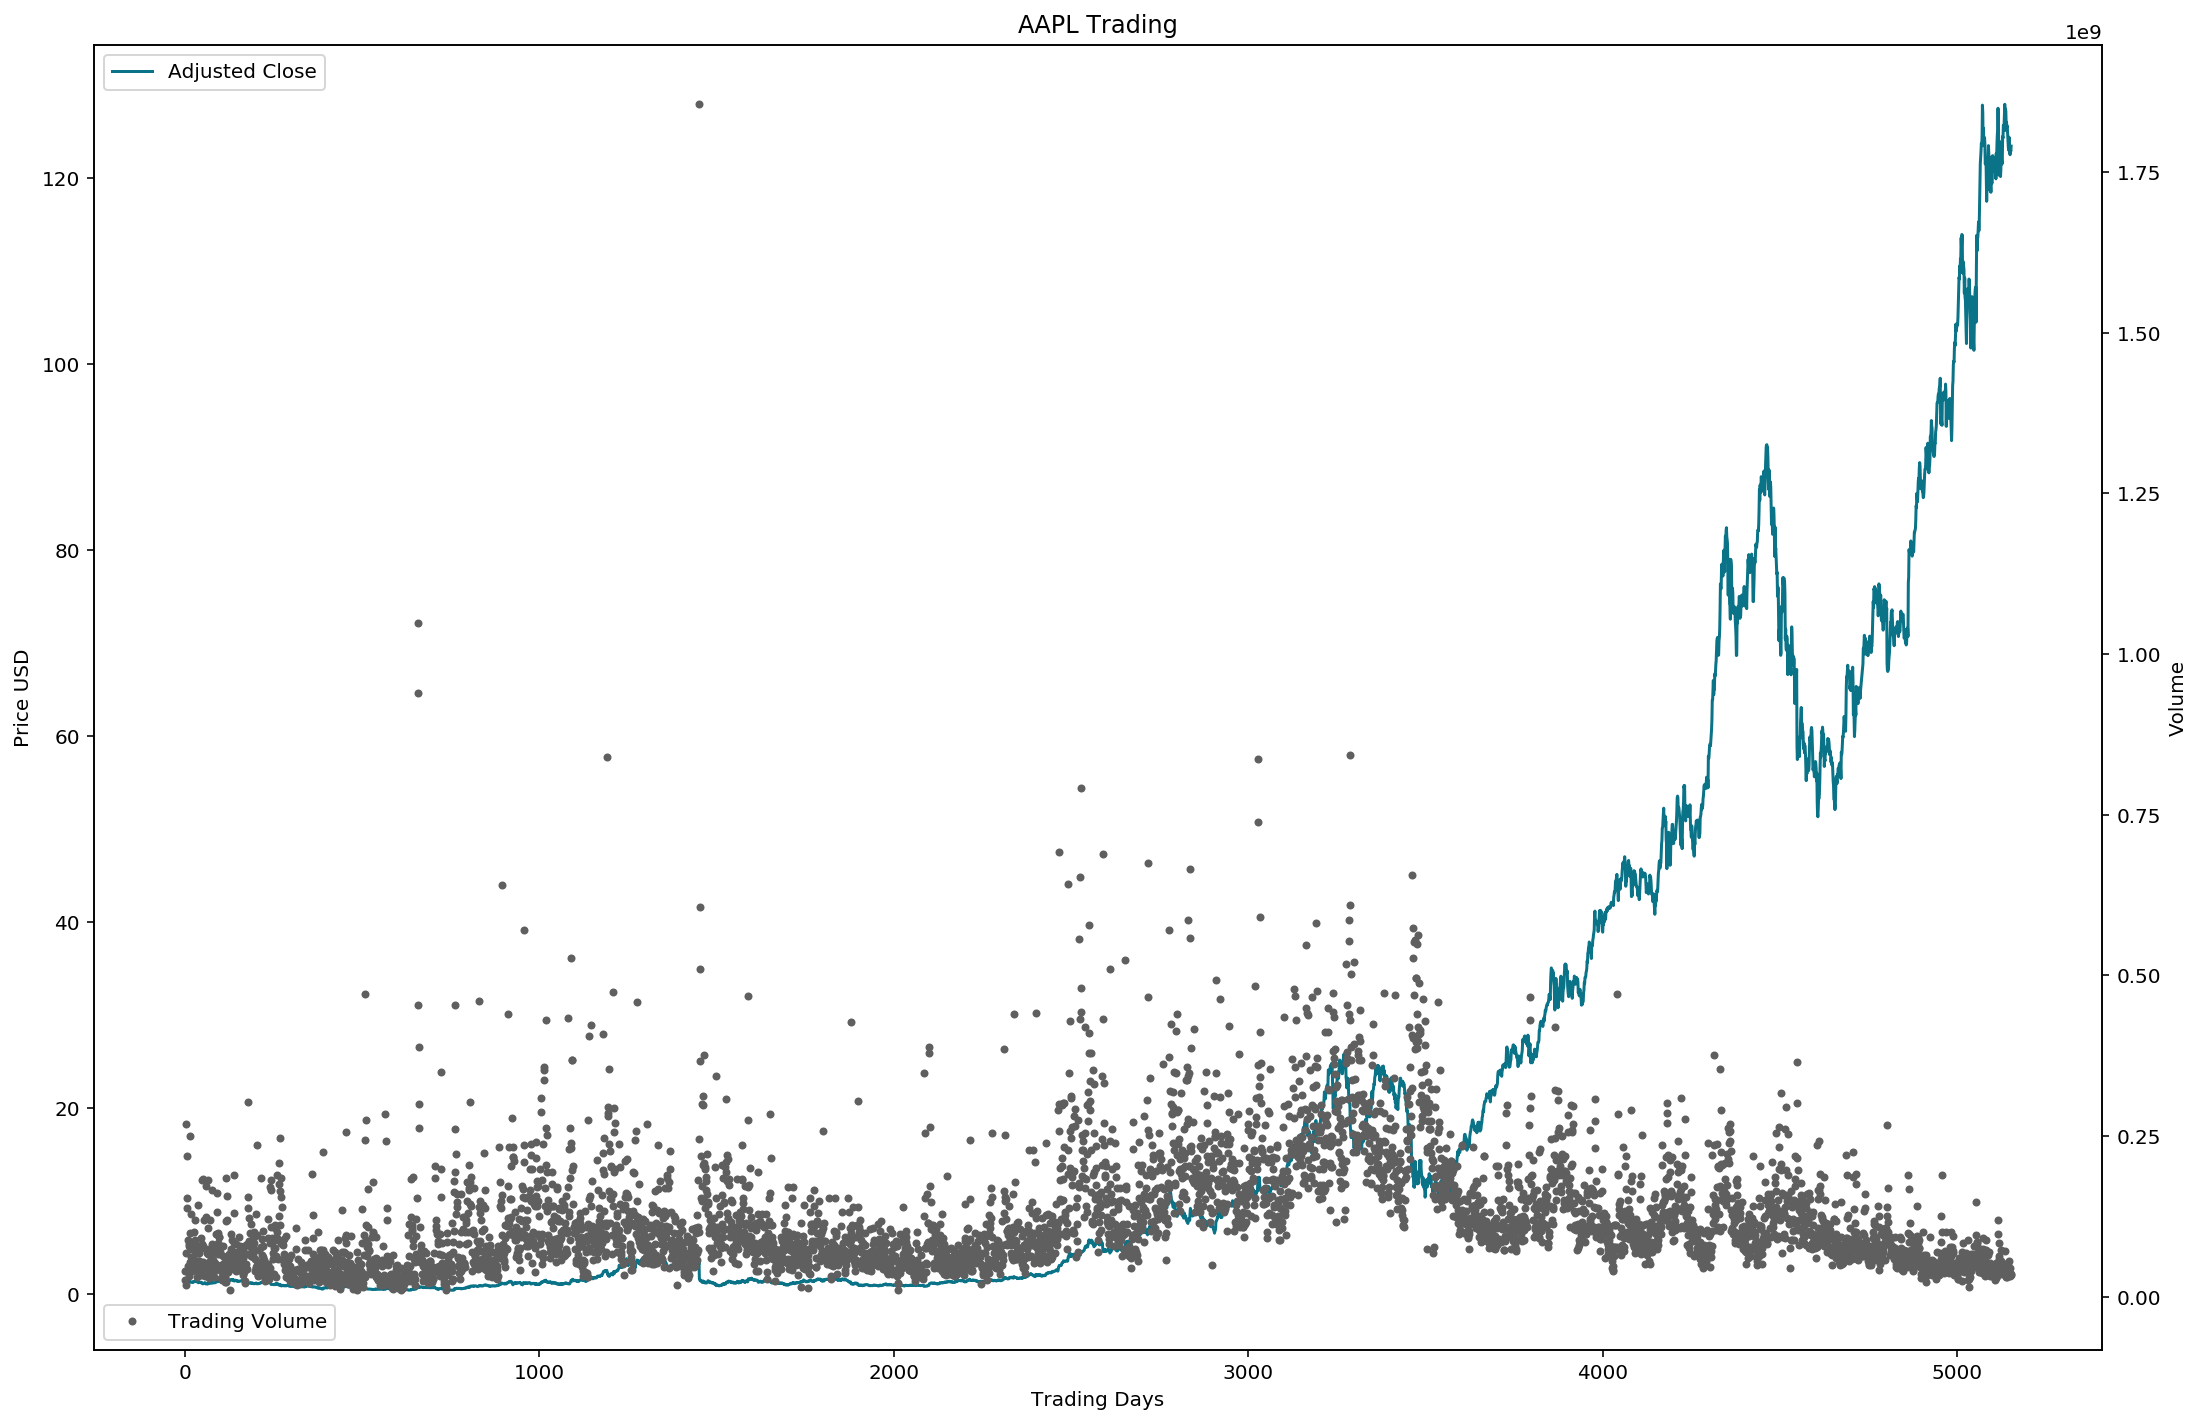

In [26]:
# Plot Basic Data
fig, ax1 = plt.subplots()
# Axis 1 - Adjusted Close
ax1.plot(stock_df['Item'], stock_df['Adj_Close'], '#0A7388', label='Adjusted Close')
# Set X Axis label
ax1.set_xlabel('Trading Days')
# Set Y Axis label
ax1.set_ylabel('Price USD')

# Axis 2 - Volume
ax2 = ax1.twinx()
ax2.plot(stock_df['Item'], stock_df['Volume'], 'r.', color='#5f5f5f', label='Trading Volume')
# Set Y Axis label
ax2.set_ylabel('Volume')

# Add labels
plt.xlabel('Trading Days')

# Add title and legend
ax1.set_title(base_ticker + ' Trading')
ax1.legend(loc='upper left')
ax2.legend(loc='lower left')

plt.show()

In [27]:
#Create numpy arrays for features and targets
day_all = []
vol_all = []
close_all = []

#Convert dataframe columns to numpy arrays 
for index, row in stock_df.iterrows():
    #print([np.array(row['Item'])])
    day_all.append(row['Item'])
    vol_all.append(row['Volume'])
    close_all.append(row['Adj_Close'])

#pprint(X_all)
#pprint(close_all)

In [28]:
# Reshape into t and t+1
look_back = 1 #50
tt_split = (1.0-.315)
#X_day_train_t, X_day_train_t1, X_day_test_t, X_day_test_t1 = create_dataset(X_day_all, look_back, tt_split, True)
#X_vol_train_t, X_vol_train_t1 = create_dataset(X_vol_train, look_back, True)
X_close_train, y_close_train, X_close_test, y_close_test, close_bounds = \
    util.create_dataset(close_all, look_back, tt_split, True)

pprint(X_close_train)
print('--')
pprint(y_close_train)

array([[[ 0.00634957]],

       [[ 0.00660065]],

       [[ 0.00647511]],

       ..., 
       [[ 0.08341128]],

       [[ 0.08889649]],

       [[ 0.09278693]]])
--
array([ 0.00660065,  0.00647511,  0.00725971, ...,  0.08889649,
        0.09278693,  0.09120231])


In [29]:
# Create Keras Model
# http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

# Set up hyperparameters
batch_size = 1
epochs = 1 # 200
n_nodes = [16,32]

# Create Stacked LSTM Network
model = Sequential()
model.add(LSTM(n_nodes[0],batch_input_shape=(batch_size, look_back, 1),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(n_nodes[1],return_sequences=False)) #, dropout_W=0.2))
model.add(Dropout(0.2))
model.add(Dense(output_dim=1))
model.add(Activation('linear'))

start = time.time()
#final_model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_squared_error', optimizer='rmsprop')
print 'compilation time : ', time.time() - start

compilation time :  0.380479812622


In [30]:
# Train the model
model.fit(
    X_close_train, 
    y_close_train,  
    nb_epoch=epochs, 
    batch_size=batch_size, 
    verbose=2, 
    validation_split=0.05)

Train on 3351 samples, validate on 177 samples
Epoch 1/1
17s - loss: 2.6778e-04 - val_loss: 9.2767e-05


In [31]:
# Generate predictions for training
#testPredict = model.predict(X_close_test, batch_size=batch_size)
testPredict = util.predict_sequences(model, X_close_test)
pprint(testPredict)

[[0.086155757],
 [0.084277079],
 [0.085856594],
 [0.083875328],
 [0.082082078],
 [0.081195205],
 [0.0789745],
 [0.077156246],
 [0.076177664],
 [0.072331727],
 [0.076643616],
 [0.081801996],
 [0.081801996],
 [0.082997255],
 [0.084015459],
 [0.087259211],
 [0.086137064],
 [0.083454922],
 [0.084744304],
 [0.08611837],
 [0.086651333],
 [0.089373723],
 [0.092426382],
 [0.095041335],
 [0.090656221],
 [0.089710675],
 [0.092004843],
 [0.091901787],
 [0.087567881],
 [0.087418199],
 [0.083931372],
 [0.084454596],
 [0.08048588],
 [0.083567038],
 [0.084417239],
 [0.082576975],
 [0.082689047],
 [0.081409886],
 [0.081811324],
 [0.084426574],
 [0.082250148],
 [0.078946516],
 [0.07690458],
 [0.082054071],
 [0.085837893],
 [0.089270763],
 [0.088877715],
 [0.088400491],
 [0.09237019],
 [0.094113208],
 [0.094206944],
 [0.094178818],
 [0.099873856],
 [0.098784737],
 [0.09877535],
 [0.10194986],
 [0.099113323],
 [0.096898422],
 [0.097489513],
 [0.10084123],
 [0.10461961],
 [0.10770565],
 [0.11002208],
 [0.

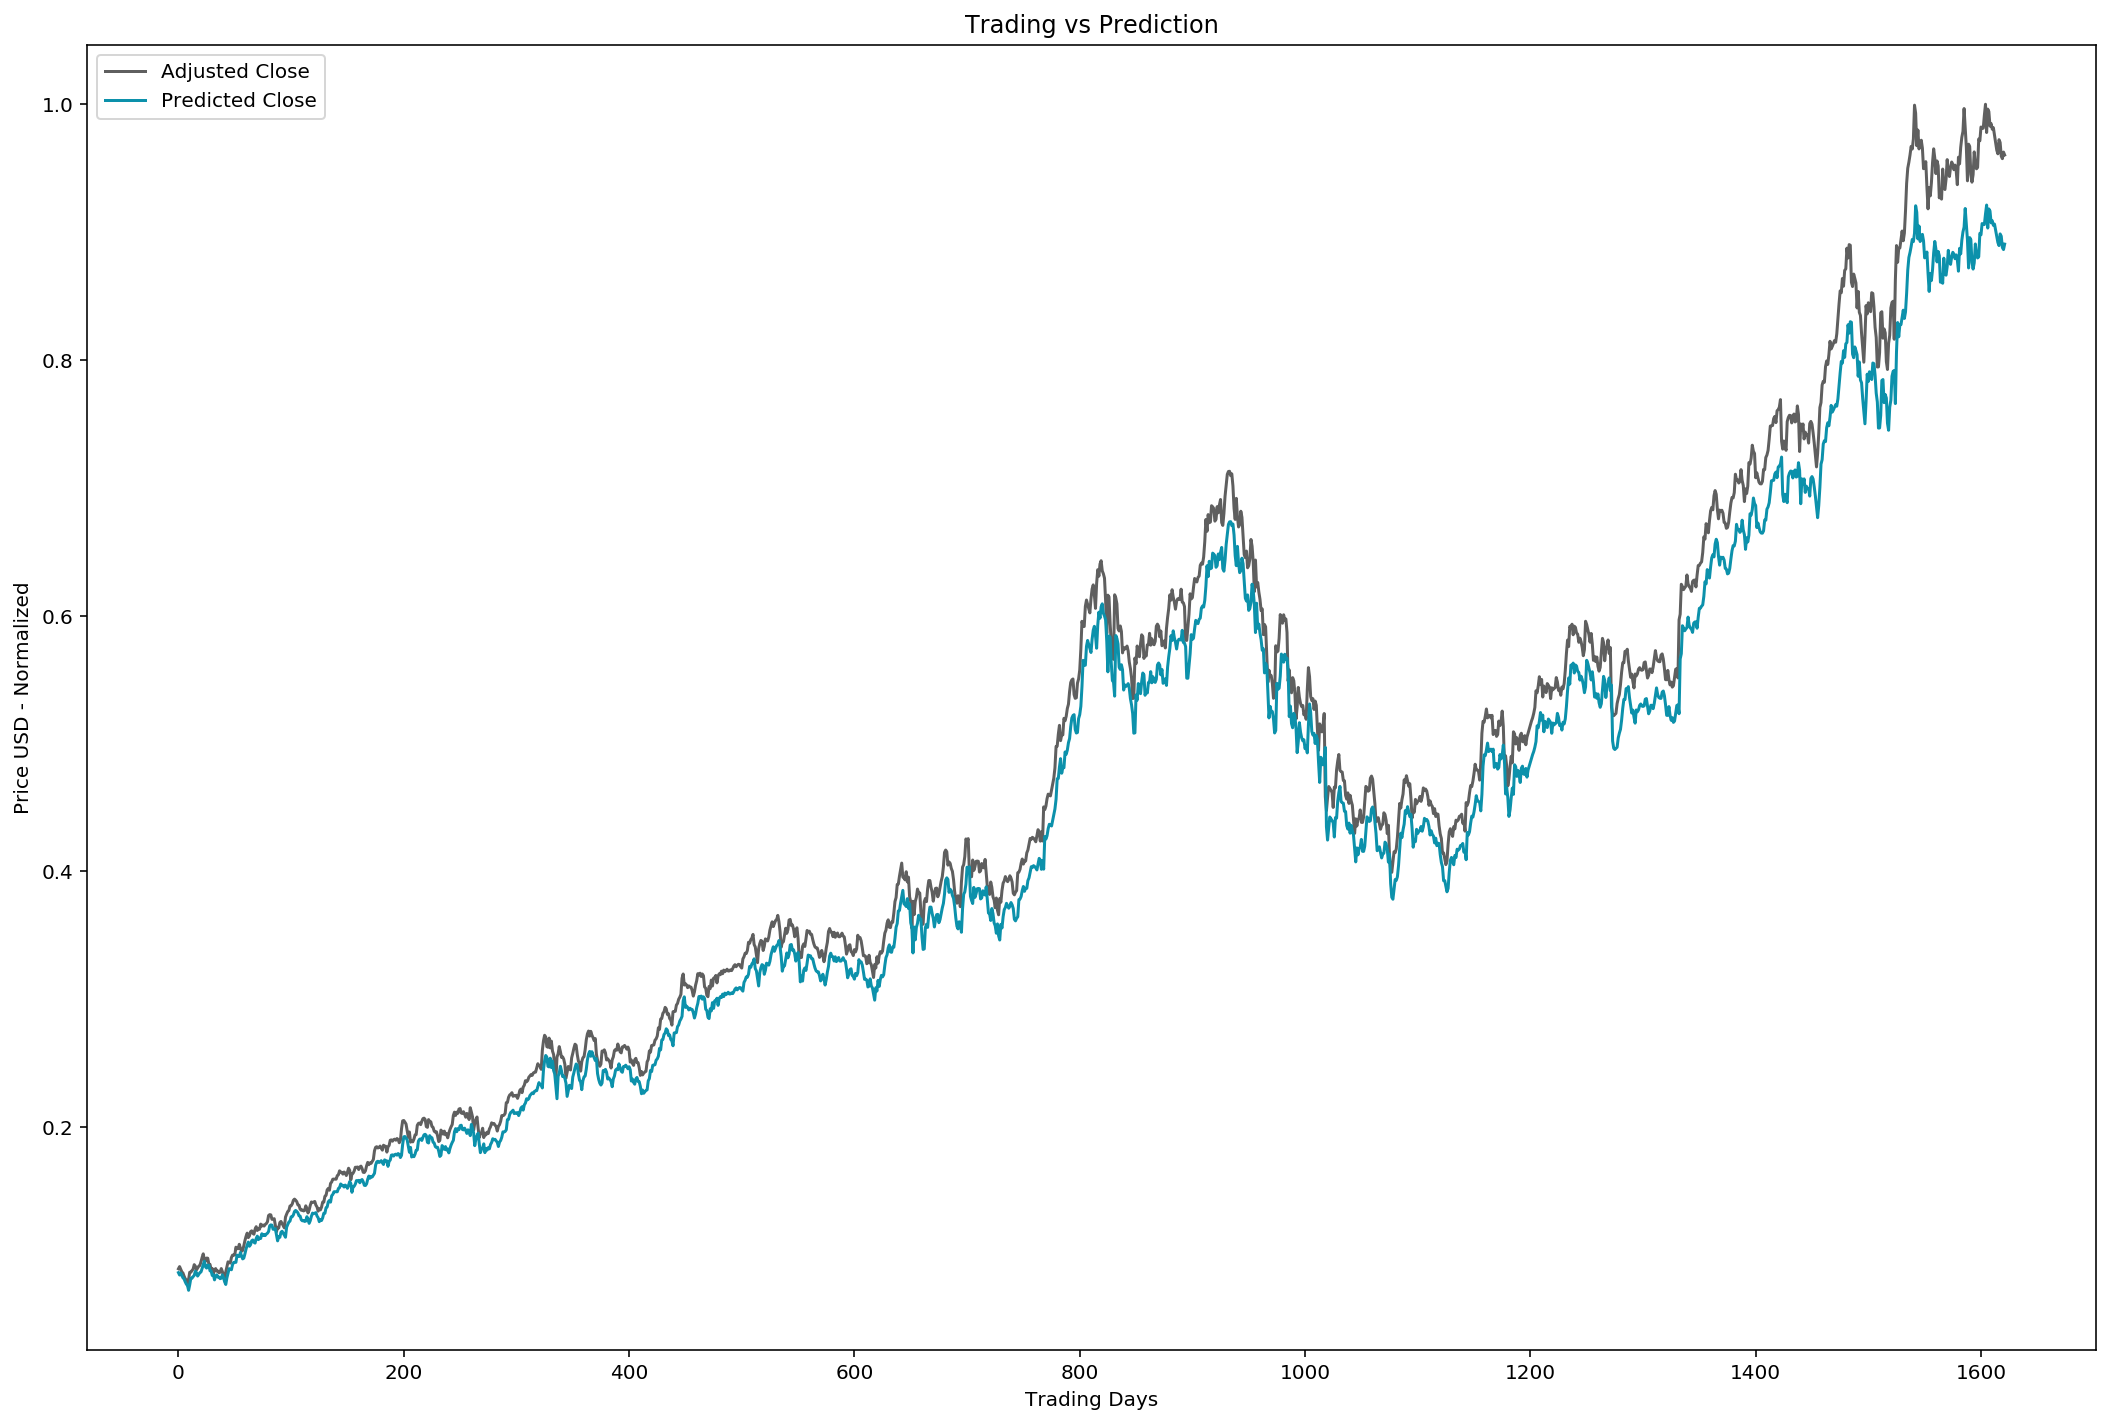

In [32]:
# Plot the predictions

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD - Normalized')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(y_close_test,'#5F5F5F', label='Adjusted Close')
plt.plot(testPredict, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title('Trading vs Prediction')
ax.legend(loc='upper left')

plt.show()

In [33]:
# The mean squared error
testScore = model.evaluate(X_close_test, y_close_test, batch_size=batch_size, verbose=0)
print('Test Score: %.5f MSE (%.5f RMSE)' % (testScore, math.sqrt(testScore)))

Test Score: 0.00101 MSE (0.03180 RMSE)


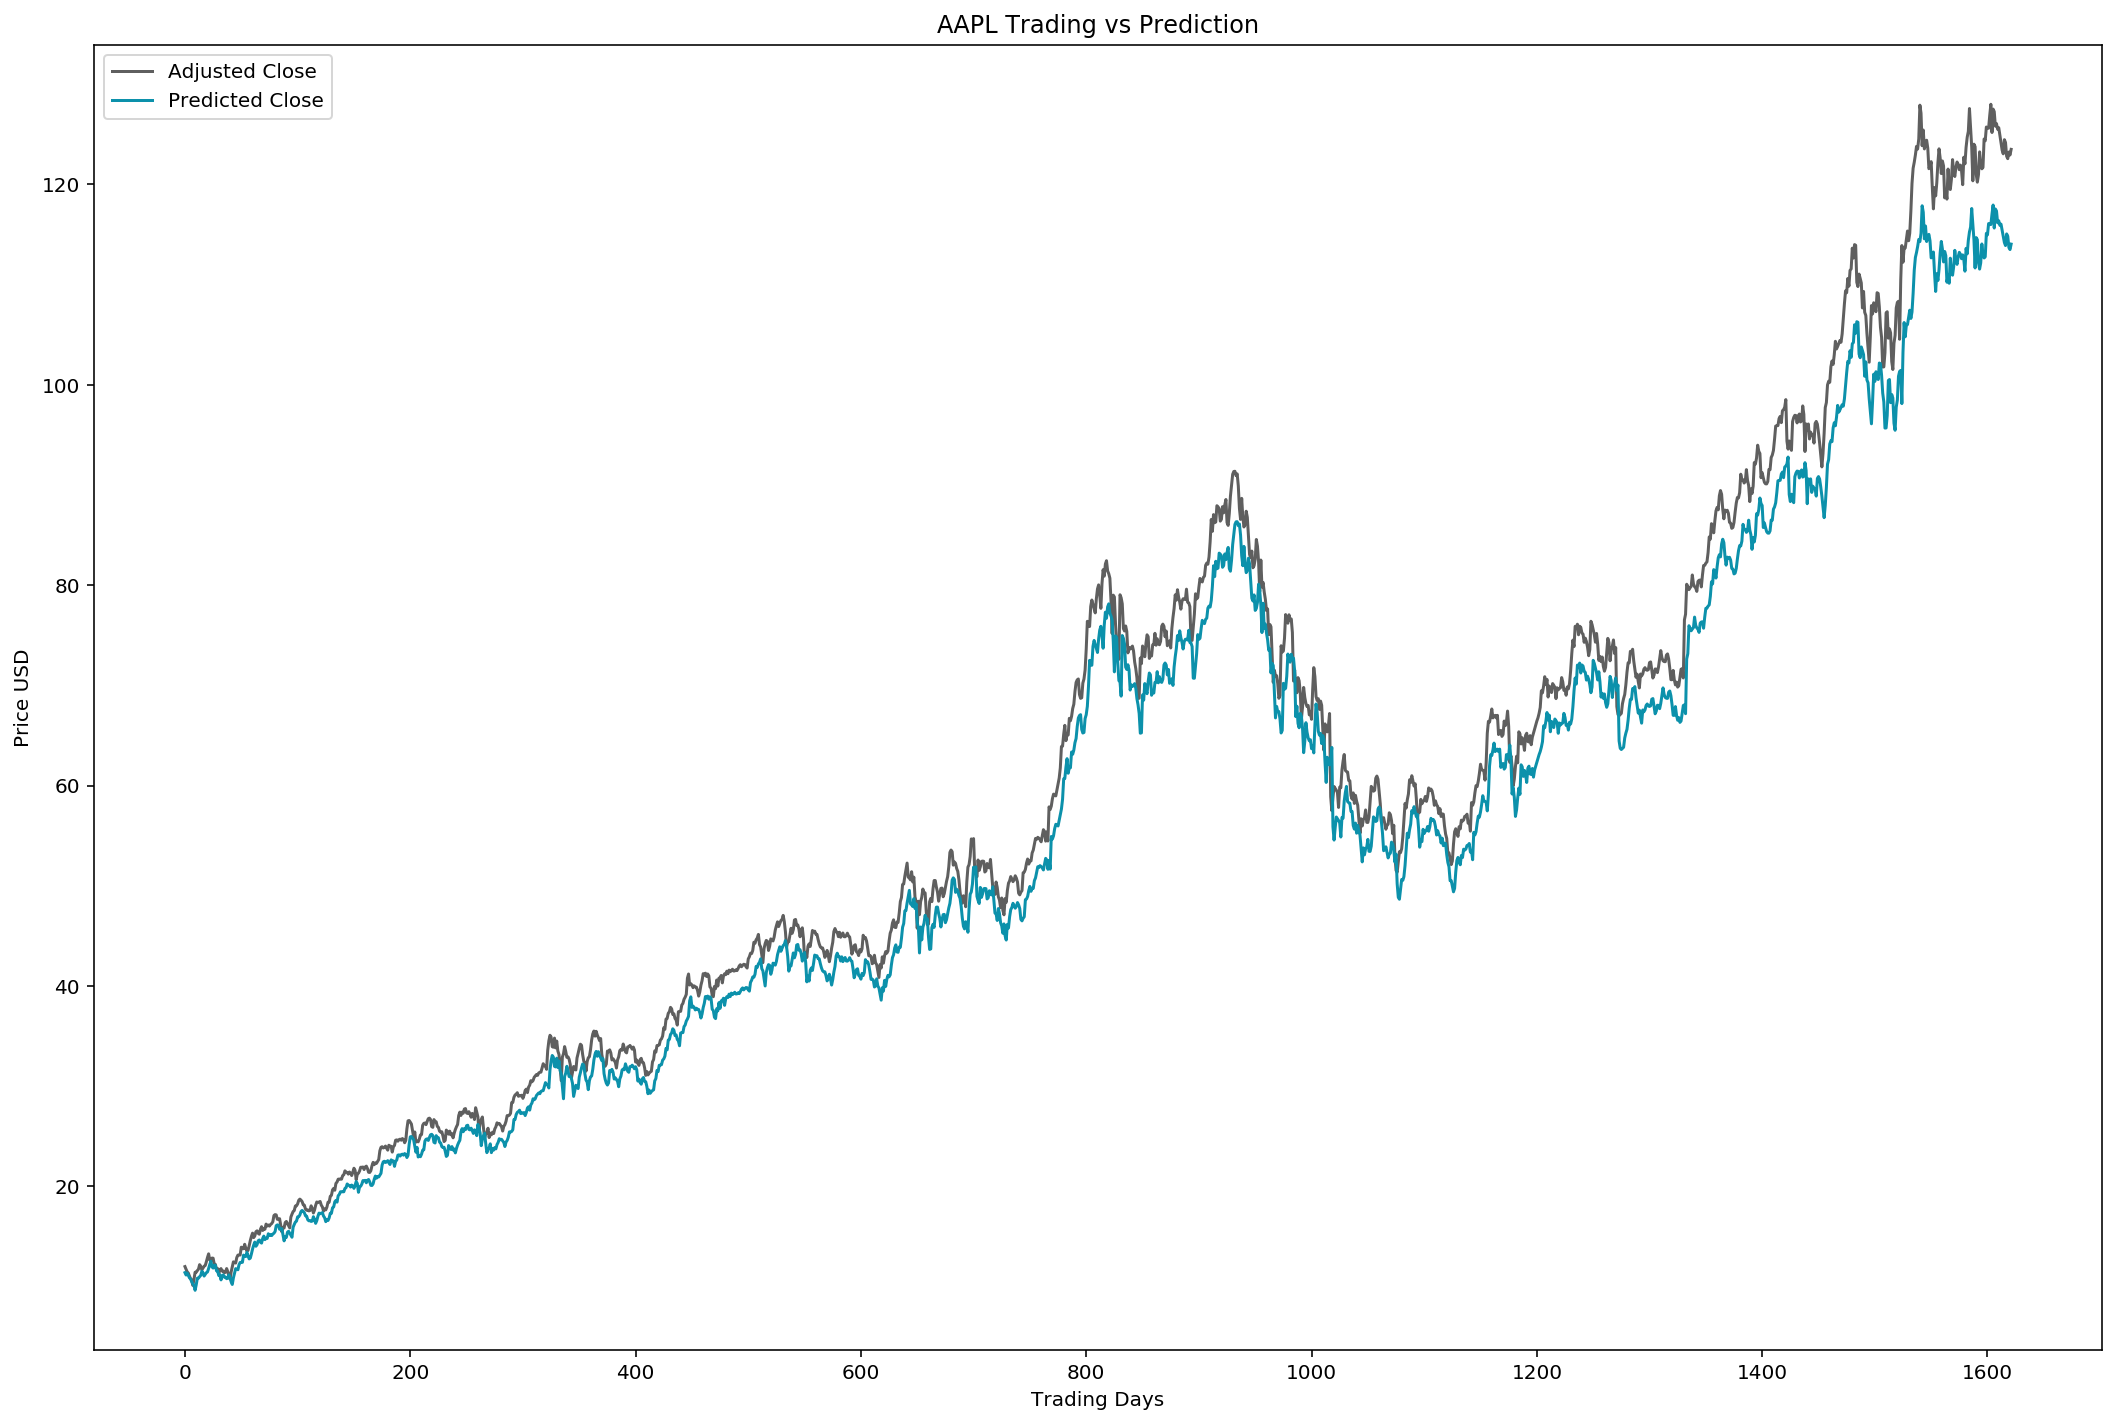

In [34]:
# Plot the predictions
close_plot = close_all[-y_close_test.shape[0]:]

pred_seq = np.array(testPredict)
#pprint(pred_seq)
preds_seq_plot, r = util.scale_range(pred_seq, input_range=[0.0,1.0], target_range=close_bounds)
#pprint(preds_seq_plot)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(close_plot,'#5F5F5F', label='Adjusted Close')
plt.plot(preds_seq_plot, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title(base_ticker + ' Trading vs Prediction')
ax.legend(loc='upper left')

# Log of Results:

### SPY
Epochs: 1 Lookback: 1 NumNodes: 16,32 Test Score: 0.00006 MSE (0.00786 RMSE)

Epochs: 1 Lookback: 1 NumNodes: 32,64 Test Score: 0.00037 MSE (0.01921 RMSE)

Epochs: 1 Lookback: 1 NumNodes: 64,128 Test Score: 0.00065 MSE (0.02557 RMSE)

Epochs: 1 Lookback: 3 NumNodes: 16,32 Test Score: 0.00334 MSE (0.05775 RMSE)

Epochs: 1 Lookback: 5 NumNodes: 16,32 Test Score: 0.00142 MSE (0.03766 RMSE)

Epochs: 1 Lookback: 10 NumNodes: 16,32 Test Score: 0.00539 MSE (0.07340 RMSE)

Epochs: 1 Lookback: 20 NumNodes: 16,32 Test Score: 0.00543 MSE (0.07370 RMSE)

Epochs: 1 Lookback: 40 NumNodes: 16,32 Test Score: 0.00458 MSE (0.06770 RMSE)


### GE
Epochs: 1 Lookback: 1 NumNodes: 16,32 Test Score: 0.00022 MSE (0.01490 RMSE)

### MSFT
Epochs: 1 Lookback: 1 NumNodes: 16,32 Test Score: 0.00015 MSE (0.01215 RMSE)


### AAPL
Epochs: 1 Lookback: 1 NumNodes: 16,32 Test Score: 0.00101 MSE (0.03180 RMSE)